# Class Definitions

These should be imported from the code library.

In [1]:
import array


class Model(object):
    """A model that produces a trajectory."""
    def __init__(self):

        self._coordinates = array.array(
            'f',
            bytearray(4 * self.n_dimensions)
        )

        self._initial_coordinates = array.array(
            'f',
            bytearray(4 * self.n_dimensions)
        )

        self._derivatives = array.array(
            'f',
            bytearray(4 * self.n_dimensions)
        )

        self._parameters = array.array(
            'f',
            bytearray(4 * self.n_parameters)
        )

    @property
    def n_dimensions(self):
        """The number of dimensions of this model."""
        raise NotImplementedError(
            self.__class__.__name__, "does not implement n_dimensions."
        )

    @property
    def n_parameters(self):
        """The number of parameters of this model."""
        raise NotImplementedError(
            self.__class__.__name__, "does not implement n_parameters."
        )

    def take_step(self) -> None:
        """Take a step along the model trajectory."""
        raise NotImplementedError(
            self.__class__.__name__, "does not implement take_step."
        )

    def set_initial_coordinates(self) -> None:
        """Set the initial coordinates to be the current coordinates."""
        for i in range(self.n_dimensions):
            self._initial_coordinates[i] = self._coordinates[i]

    def reset(self) -> None:
        """Return the trajectory to the initial coordinates."""
        for i in range(self.n_dimensions):
            self._coordinates[i] = self._initial_coordinates[i]


In [2]:
import random


class LorenzSystem(Model):
    """The Lorenz system of ordinary differential equations.

    Parameters
    ----------
    x
        The current x-coordinate. Default starting value is 0.0.
    y
        The current y-coordinate. Default starting value is 1.0.
    z
        The current z-coordinate. Default starting value is 1.05.
    sigma
        Default value is 10.
    rho
        Default value is 28.
    beta
        Default value is 8/3.
    timestep
        The size of the step (in time units) to take.
        Default of 0.01 was determined by experimentation only.
    random_factor
        The maximum magnitude of the perturbation applied at reset.

    Properties
    ----------
    n_dimensions -> int
        The number of dimensions of this model.
    n_parameters -> int
        The number of parameters of this model.

    Methods
    -------
    take_step
        Take a step along the trajectory.
    set_initial_coordinates
        Set the initial coordinates to be the current coordinates.
    reset
        Return the trajectory to the initial coordinates.
    """
    def __init__(self,
                 x: float = 0.9,
                 y: float = 0.0,
                 z: float = 0.0,
                 sigma: float = 10.0,
                 rho: float = 28,
                 beta: float = 8 / 3,
                 timestep: float = 0.01,
                 random_factor=None):

        super().__init__()

        self._coordinates = [x, y, z]
        self._initial_coordinates = [x, y, z]
        self._parameters = [sigma, rho, beta]

        self._timestep = timestep

        self._random_factor = random_factor

        self._crossed_zero = False

    @property
    def n_dimensions(self) -> int:
        return 3

    @property
    def n_parameters(self) -> int:
        return 3

    def reset(self) -> None:
        """Return the trajectory to the initial coordinates."""
        super().reset()
        if self._random_factor:
            for i in range(self.n_dimensions):
                self._coordinates[i] += self._random_factor * random.random()

    def __compute_derivatives(self):
        """Determine the partial derivatives at the current coordinates."""
        self._derivatives = [
            self._parameters[0] * (
                        self._coordinates[1] - self._coordinates[0]),
            self._coordinates[0] * (
                        self._parameters[1] - self._coordinates[2]) -
            self._coordinates[1],
            (self._coordinates[0] * self._coordinates[1]) - (
                        self._parameters[2] * self._coordinates[2])
        ]

    def take_step(self) -> None:
        """Determine the value of f(t_n+1, x, y, z) at the next timestep.

        This stepper uses the most basic possible scheme to integrate
        the ODEs of the system; Euler's method. This only requires a
        single evaluation of f(t, x, y, z) so is cheap, but is only accurate
        on the order of the square of the timestep.
        """
        previous_x = self._coordinates[0]

        self.__compute_derivatives()

        for i in range(self.n_dimensions):
            self._coordinates[i] += self._derivatives[i] * self._timestep

        if (previous_x * self._coordinates[0]) < 0:
            self._crossed_zero = True
        else:
            self._crossed_zero = False

In [3]:
class Looper(object):
    """A looper for models.

    Parameters
    ----------
    models
        A list of the models to be looped.
    looping
        Whether to being looping on instantiation.
        Default value is False.
    """
    def __init__(self,
                 models: list,
                 looping: bool = False):

        self._models = models
        self._looping = looping

        self._counter = 0
        self._num_steps = None

    def set_initial_coordinates(self) -> None:
        """Set the initial coordinates of all the looped models."""
        self.reset()
        for model in self._models:
            model.set_initial_coordinates()

    def reset(self) -> None:
        """Return the model trajectories to their initial coordinates."""
        self._counter = 0

    def start_looping(self) -> None:
        """Start looping the models.

        On loop start, the current position of the model will be used as the
        final position for the loop. To enable this behaviour, the number of
        steps taken since the start point was set is saved, and the counter is
        reset to zero. Turning on the looping indicator means that the method
        taking model steps will check if the counter hits the desired number of
        steps and restart.
        """
        self._looping = True
        self._num_steps = self._counter
        self.reset()
        for model in self._models:
            model.reset()

    def stop_looping(self) -> None:
        """Stop looping the models.

        On stopping the loop, the start position is retained but the final
        position is not kept, since it is set when the loop begins. The counter
        continues to count from the start point in case the looping is started
        again, so that the start point is kept.
        """
        self._looping = False
        self._num_steps = None

    def take_step(self) -> None:
        """Take a step along each model's trajectory.

        If the system is not being looped, this method just takes a step on the
        model trajectory and increments the counter. If the number of steps in
        the loop has been reached, the looper is at the end of its loop and so
        moves the system back to its initial coordinates and resets the
        counter. At the end of a loop, the "step" is to return to the model's
        initial position, so take_step is not called as this would result in a
        double step in a single cycle.
        """
        if self._looping:
            if self._counter == self._num_steps:
                for model in self._models:
                    model.reset()

                self.reset()
                return

        for model in self._models:
            model.take_step()

        self._counter += 1


# Plot an Example Trajectory

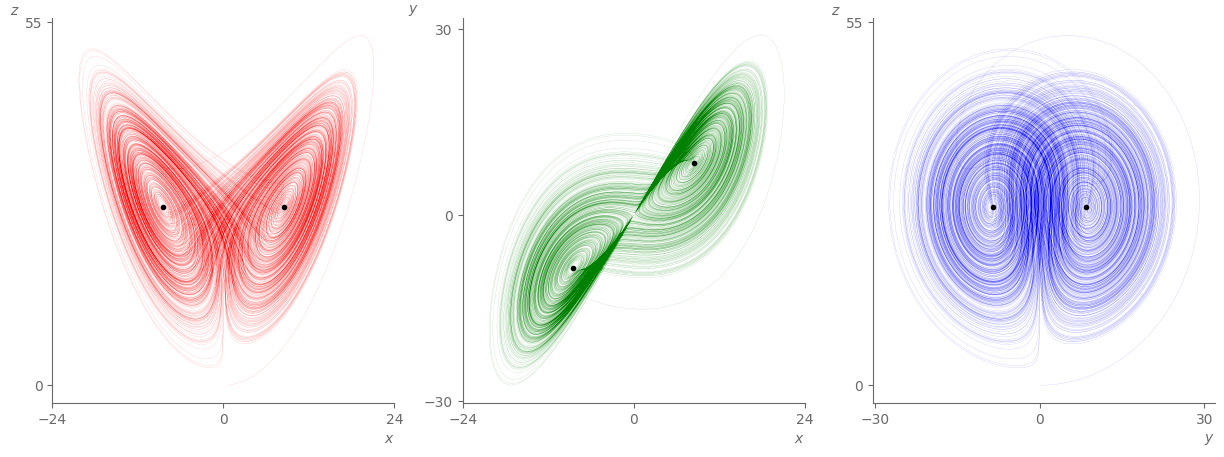

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


N = 60000
n_plot = 0

lorenz_system = LorenzSystem(timestep=0.008)

fixed_point_a_x = np.sqrt(lorenz_system._parameters[2] * (lorenz_system._parameters[1] - 1))
fixed_point_a_y = fixed_point_a_x
fixed_point_a_z = lorenz_system._parameters[1] - 1

fixed_point_b_x = -fixed_point_a_x
fixed_point_b_y = fixed_point_b_x
fixed_point_b_z = fixed_point_a_z

xyz_values = np.empty(shape=(N, 3))
xyz_values[0, :] = lorenz_system._coordinates

for i in range(1, N):
    lorenz_system.take_step()
    xyz_values[i, :] = lorenz_system._coordinates

fig, axes = plt.subplots(1, 3, sharex=False)

x_min = -24
x_max = 24
y_min = -30
y_max = 30
z_min = 0
z_max = 55

axis_color = "dimgray"
markercolor = "black"
markertype="o"
markersize = 3
lw=0.05

axes[0].plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 2], lw=lw, c="red")
axes[0].plot([fixed_point_a_x], [fixed_point_a_z], marker=markertype, color=markercolor, markersize=markersize)
axes[0].plot([fixed_point_b_x], [fixed_point_b_z], marker=markertype, color=markercolor, markersize=markersize)
axes[0].set_xlabel(r'$x$', loc='right', color=axis_color)
axes[0].set_ylabel(r'$z$', loc='top', color=axis_color, rotation=0)
axes[0].set_xticks([x_min, 0, x_max])
axes[0].set_yticks([z_min, z_max])

axes[1].plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 1], lw=lw, c="green")
axes[1].plot([fixed_point_a_x], [fixed_point_a_y], marker=markertype, color=markercolor, markersize=markersize)
axes[1].plot([fixed_point_b_x], [fixed_point_b_y], marker=markertype, color=markercolor, markersize=markersize)
axes[1].set_xlabel(r'$x$', loc='right', color=axis_color)
axes[1].set_ylabel(r'$y$', loc='top', color=axis_color, rotation=0)
axes[1].set_xticks([x_min, 0, x_max])
axes[1].set_yticks([y_min, 0, y_max])

axes[2].plot(xyz_values[n_plot:, 1], xyz_values[n_plot:, 2], lw=lw, c="blue")
axes[2].plot([fixed_point_a_y], [fixed_point_a_z], marker=markertype, color=markercolor, markersize=markersize)
axes[2].plot([fixed_point_b_y], [fixed_point_b_z], marker=markertype, color=markercolor, markersize=markersize)
axes[2].set_xlabel(r'$y$', loc='right', color=axis_color)
axes[2].set_ylabel(r'$z$', loc='top', color=axis_color, rotation=0)
axes[2].set_xticks([y_min, 0, y_max])
axes[2].set_yticks([z_min, z_max])

for i in range(3):
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].spines[['left', 'bottom']].set_color(axis_color)
    axes[i].tick_params(axis='x', colors=axis_color)
    axes[i].tick_params(axis='y', colors=axis_color)

fig.set_size_inches(15, 5)
plt.savefig(r'../docs/graphics/lorenz_attractor.png', bbox_inches='tight', transparent=True)

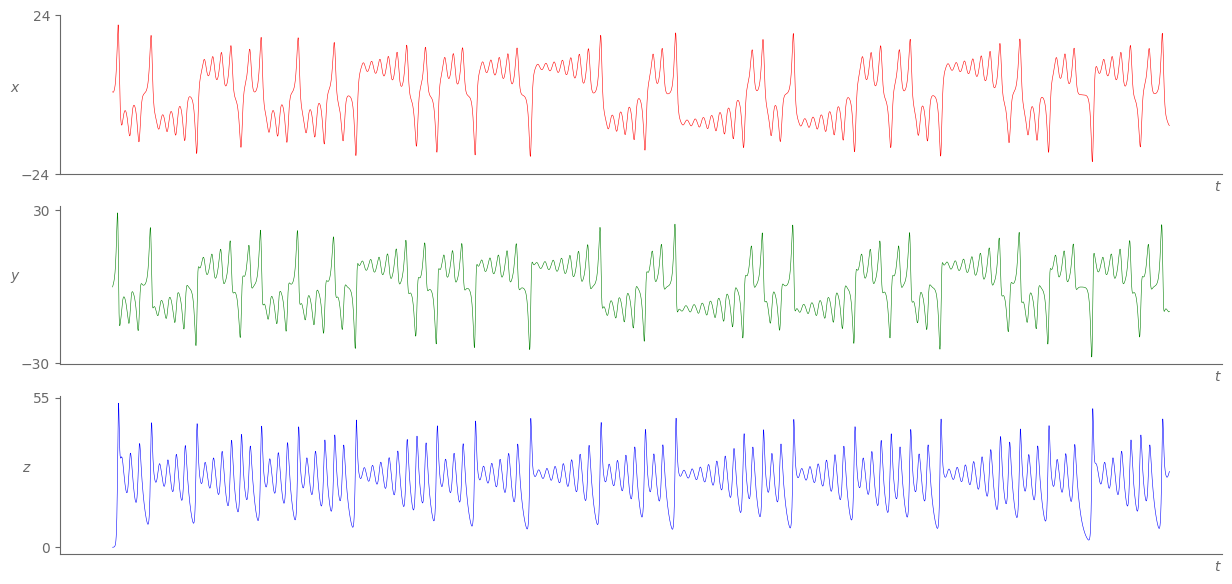

In [5]:
stop = 10000

fig, axes = plt.subplots(3, 1, sharex=True)

axes[2].plot(xyz_values[0:stop, 2], lw=0.4, c="blue")
axes[2].set_yticks([z_min, z_max])
axes[2].set_ylabel(r'$z$', loc='center', color=axis_color, rotation=0)


axes[1].plot(xyz_values[0:stop:, 1], lw=0.4, c="green")
axes[1].set_yticks([y_min, y_max])
axes[1].set_ylabel(r'$y$', loc='center', color=axis_color, rotation=0)

axes[0].plot(xyz_values[0:stop:, 0], lw=0.4, c="red")
axes[0].set_yticks([x_min, x_max])
axes[0].set_ylabel(r'$x$', loc='center', color=axis_color, rotation=0)

axes[0].set_xticks([])

for i in range(3):
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].spines[['left', 'bottom']].set_color(axis_color)
    axes[i].tick_params(axis='x', colors=axis_color)
    axes[i].tick_params(axis='y', colors=axis_color)
    axes[i].set_xlabel(r'$t$', loc='right', color=axis_color)

    
fig.set_size_inches(15, 7)
plt.savefig(r'../docs/graphics/control_voltages.png', bbox_inches='tight', transparent=True)

# Looping without Sensitivity to Initial Conditions

The system can be looped without making use of the property of sensitivity to initial conditions. To achieve this, no perturbation of the initial coordinates of the system is carried out at the start of the loop. Loops of this kind will repeat indefinitely until looping is turned off, unless the start point is altered (which will by definition shorten the loop).

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

N = 10000
n_plot = 0

lorenz_system = LorenzSystem(timestep=0.008)
looper = Looper(models=[lorenz_system])

xyz_values = np.empty(shape=(N, 3))
xyz_values[0, :] = lorenz_system._coordinates

for i in range(0, 2000):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

looper.start_looping()
for i in range(2000, 6000):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

looper.stop_looping()
for i in range(6000, N):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

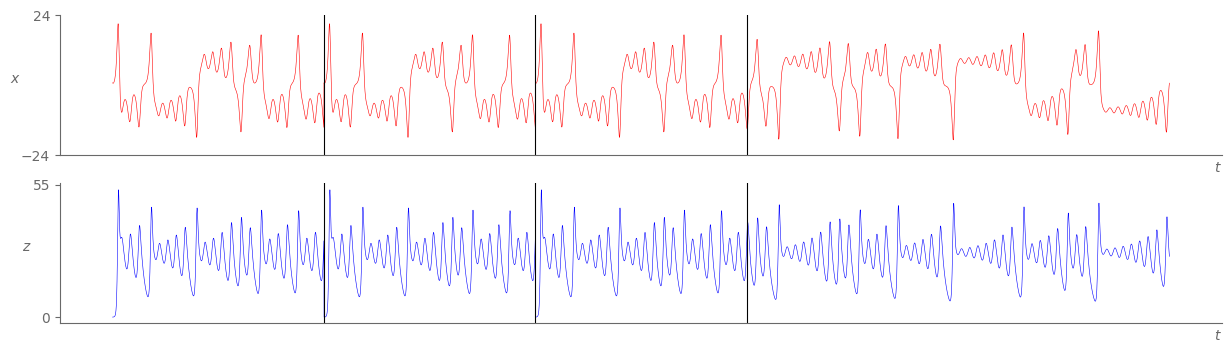

In [7]:
stop = 10000

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(xyz_values[0:stop:, 0], lw=0.4, c="red")
axes[0].set_yticks([x_min, x_max])
axes[0].set_ylabel(r'$x$', loc='center', color=axis_color, rotation=0)

axes[1].plot(xyz_values[0:stop, 2], lw=0.4, c="blue")
axes[1].set_yticks([z_min, z_max])
axes[1].set_ylabel(r'$z$', loc='center', color=axis_color, rotation=0)

axes[0].set_xticks([])

for i in range(2):
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].spines[['left', 'bottom']].set_color(axis_color)
    axes[i].tick_params(axis='x', colors=axis_color)
    axes[i].tick_params(axis='y', colors=axis_color)
    axes[i].set_xlabel(r'$t$', loc='right', color=axis_color)

for i in range(2):
    axes[i].axvline(2000, color="black", lw=0.8, linestyle="-")
    axes[i].axvline(4000, color="black", lw=0.8, linestyle="-")
    axes[i].axvline(6000, color="black", lw=0.8, linestyle="-")

fig.set_size_inches(15, 4)
plt.savefig(r'../docs/graphics/looping_voltages.png', bbox_inches='tight', transparent=True)

# Looping with Sensitivity to Initial Conditions

The looping behaviour may be made more variable by making use of the sensitivity to initial conditions of the Lorenz system. In this case a controllable perturbation is added to the system's position at the beginning of the loop. This results in loops where the output diverges over the course of the loop, being most similar at first and ending up completely different. Making the perturbation factor larger results in faster deviation from the original trajectory, and smaller results in subtler differences at the end of a loop.

The simulation below shows two cases, one where a relatively small perturbation is applied at the beginning of the loop, and one where a larger perturbation is applied. Setting the perturbation to a very high value is equivalent to moving the starting point a great distance in space from the stored initial coordinates. This is not the same as turning off looping but will result in dissimilar chunks of control voltage.

In these cases, the x,y visualization of the trajectory is not particularly enlightening and only the CV output plots are included.

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

N = 10000
n_plot = 0

lorenz_system = LorenzSystem(timestep=0.008, random_factor=0.05)
looper = Looper(models=[lorenz_system])

xyz_values = np.empty(shape=(N, 3))
xyz_values[0, :] = lorenz_system._coordinates

for i in range(0, 2000):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

looper.start_looping()
for i in range(2000, 6000):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

looper.stop_looping()
for i in range(6000, N):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

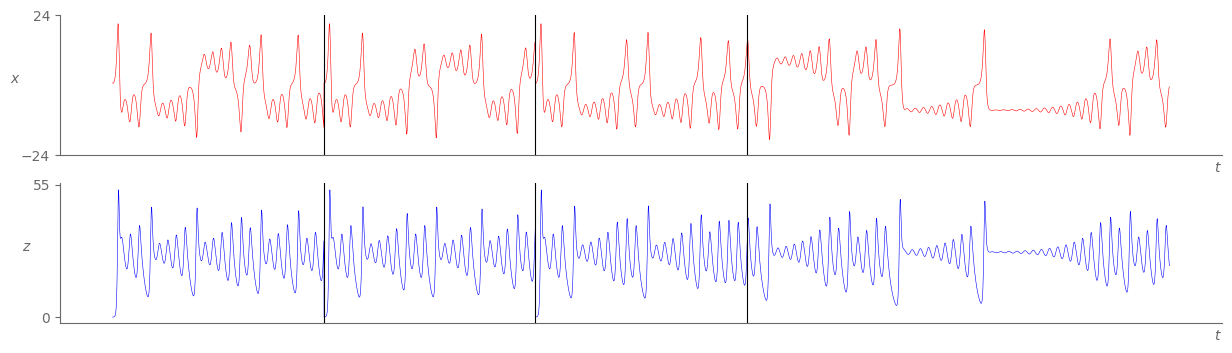

In [9]:
stop = 10000

fig, axes = plt.subplots(2, 1, sharex=True)

axes[1].plot(xyz_values[0:stop, 2], lw=0.4, c="blue")
axes[1].set_yticks([z_min, z_max])
axes[1].set_ylabel(r'$z$', loc='center', color=axis_color, rotation=0)

axes[0].plot(xyz_values[0:stop:, 0], lw=0.4, c="red")
axes[0].set_yticks([x_min, x_max])
axes[0].set_ylabel(r'$x$', loc='center', color=axis_color, rotation=0)

axes[0].set_xticks([])

for i in range(2):
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].spines[['left', 'bottom']].set_color(axis_color)
    axes[i].tick_params(axis='x', colors=axis_color)
    axes[i].tick_params(axis='y', colors=axis_color)
    axes[i].set_xlabel(r'$t$', loc='right', color=axis_color)

for i in range(2):
    axes[i].axvline(2000, color="black", lw=0.8, linestyle="-")
    axes[i].axvline(4000, color="black", lw=0.8, linestyle="-")
    axes[i].axvline(6000, color="black", lw=0.8, linestyle="-")
    
fig.set_size_inches(15, 4)
plt.savefig(r'../docs/graphics/dependent_loop.png', bbox_inches='tight', transparent=True)

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

N = 10000
n_plot = 0

lorenz_system = LorenzSystem(timestep=0.008, random_factor=10)
looper = Looper(models=[lorenz_system])

xyz_values = np.empty(shape=(N, 3))
xyz_values[0, :] = lorenz_system._coordinates

for i in range(0, 2000):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

looper.start_looping()
for i in range(2000, 6000):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

looper.stop_looping()
for i in range(6000, N):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

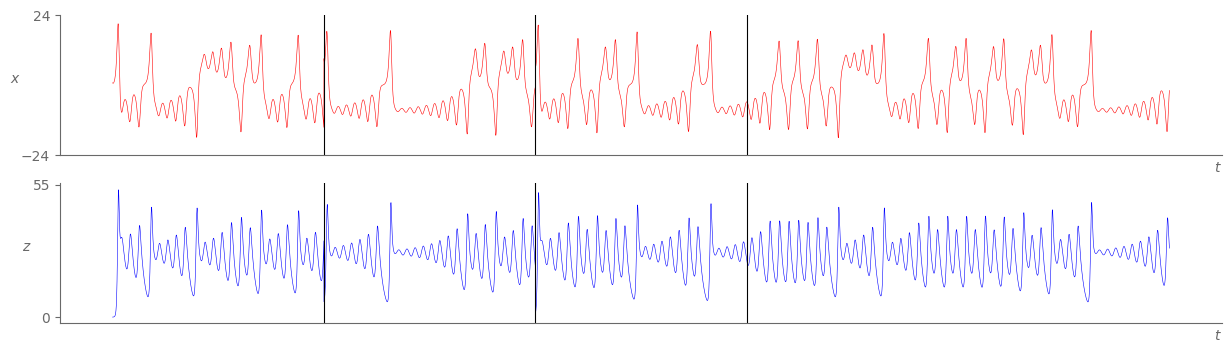

In [11]:
stop = 10000

fig, axes = plt.subplots(2, 1, sharex=True)

axes[1].plot(xyz_values[0:stop, 2], lw=0.4, c="blue")
axes[1].set_yticks([z_min, z_max])
axes[1].set_ylabel(r'$z$', loc='center', color=axis_color, rotation=0)

axes[0].plot(xyz_values[0:stop:, 0], lw=0.4, c="red")
axes[0].set_yticks([x_min, x_max])
axes[0].set_ylabel(r'$x$', loc='center', color=axis_color, rotation=0)

axes[0].set_xticks([])

for i in range(2):
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].spines[['left', 'bottom']].set_color(axis_color)
    axes[i].tick_params(axis='x', colors=axis_color)
    axes[i].tick_params(axis='y', colors=axis_color)
    axes[i].set_xlabel(r'$t$', loc='right', color=axis_color)

for i in range(2):
    axes[i].axvline(2000, color="black", lw=0.8, linestyle="-")
    axes[i].axvline(4000, color="black", lw=0.8, linestyle="-")
    axes[i].axvline(6000, color="black", lw=0.8, linestyle="-")
    
fig.set_size_inches(15, 4)
plt.savefig(r'../docs/graphics/very_dependent_loop.png', bbox_inches='tight', transparent=True)